In [222]:
import pandas as pd
import numpy as np
import tensorflow as tlf
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf

from keras.datasets import fashion_mnist
from tensorflow.keras import models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, GaussianNoise, AveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [223]:
train_dir = "dataset/cats_and_dogs_small/train/"
val_dir = "dataset/cats_and_dogs_small/validation/"
test_dir = "dataset/cats_and_dogs_small/test"

In [224]:
CLASSES_NAMES = ["cats", "dogs"]

## Read dataset

In [225]:
BATCH_SIZE = 32

### Data augmenting

In [226]:
def to_grayscale_then_rgb(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return image

In [227]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      zoom_range=0.2,
      preprocessing_function=to_grayscale_then_rgb,
      horizontal_flip=True,
      fill_mode='nearest')
val_datagen = ImageDataGenerator(
      rescale=1./255,
      zoom_range=0.2,
      rotation_range=30,
      preprocessing_function=to_grayscale_then_rgb,
      horizontal_flip=True)
test_datagen = ImageDataGenerator(
      rescale=1./255,
      zoom_range=0.2,
      rotation_range=30,
      preprocessing_function=to_grayscale_then_rgb,
      horizontal_flip=True)

In [228]:
train_data = train_datagen.flow_from_directory(train_dir, batch_size=BATCH_SIZE, target_size=(224, 224), class_mode="sparse")
val_data = val_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=BATCH_SIZE, class_mode="sparse")
test_data = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=BATCH_SIZE, class_mode="sparse")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1030 images belonging to 2 classes.


In [229]:
input_shape = train_data.image_shape
output_shape = len(train_data.class_indices)

In [230]:
print(input_shape)
print(output_shape)
print(train_data.samples)
print(val_data.samples)
print(test_data.samples)

(224, 224, 3)
2
2000
1000
1030


- What is the dataset about? 
  - The dataset is about the images of dogs and cats, organized by directories for labeling
- Also describes the following characteristics: number of classes, number of samples, how the samples are split, sample size, value type.
  - classes: 2 classes, dog and cat
  - number of samples: 2000 training, 1000 validation, 1030 testing (4030 total)
  - value type: images and labels in 0 to n values


## Create Model Functions

In [231]:
def create_model(shape, output_shape, model_type):
    model = Sequential()

    if model_type == "resnet":
        resnet = tf.keras.applications.ResNet50V2(
                    include_top=False,
                    weights="imagenet",
                    input_tensor=None,
                    input_shape=shape,
                    pooling=None)

        for layer in resnet.layers:
	        layer.trainable = False
            
        model.add(resnet)

        model.add(GlobalAveragePooling2D())
        model.add(Dense(256, activation='elu'))
        model.add(Dense(256, activation='elu'))
    elif model_type == "mobilenet":
        mobilenet = tf.keras.applications.MobileNetV2(
                    include_top=False,
                    weights="imagenet",
                    input_tensor=None,
                    input_shape=shape,
                    pooling=None)

        mobilenet.trainable = False

        for layer in mobilenet.layers:
	        layer.trainable = False

        model.add(mobilenet)

        model.add(Flatten())
        model.add(Dense(256, activation='elu'))
        model.add(Dense(256, activation='elu'))
    elif model_type == "densenet":
        densenet = tf.keras.applications.DenseNet201(
                    include_top=False,
                    weights="imagenet",
                    input_tensor=None,
                    input_shape=shape,
                    pooling=None)

        for layer in densenet.layers:
	        layer.trainable = False

        model.add(densenet)

        model.add(Flatten())
        model.add(Dense(256, activation='elu'))
        model.add(Dense(256, activation='elu'))

    model.add(Dense(output_shape, activation='softmax')) # classifier, (10 amount of outputs to classify)

    return model

In [232]:
def compile_model(model, loss_func, optimizer, metrics=["accuracy"]):
   model.compile(loss=loss_func, optimizer=optimizer, metrics=metrics)

In [233]:
def fit_model(model, train_data, validation_data=(), batch_size=32, epochs=10, callbacks=[]):
    return model.fit(train_data, validation_data=validation_data, batch_size=batch_size, epochs=epochs, callbacks=callbacks)

In [234]:
def evaluate_model(model, values):
  score = model.evaluate(values)
  return score

In [235]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def confusion_matrix_model(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    cmdis = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES_NAMES)


    cmdis.plot(cmap=plt.cm.Blues)
    plt.show()

## Create First Model

In [236]:
first_model = create_model(input_shape, output_shape, "resnet")

In [237]:
first_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_6   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_37 (Dense)            (None, 256)               524544    
                                                                 
 dense_38 (Dense)            (None, 256)               65792     
                                                                 
 dense_39 (Dense)            (None, 2)                 514       
                                                                 
Total params: 24,155,650
Trainable params: 590,850
Non-trainable params: 23,564,800
___________________________________

### Compile model

In [238]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                            filepath="checkpoints/cnn_4_model_1_best_weights.hdf5",
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [239]:
sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(learning_rate=1e-3, decay=1e-3 / 300)

compile_model(first_model, 'sparse_categorical_crossentropy', adam)

In [240]:
first_history = fit_model(first_model, train_data, validation_data=val_data, epochs=20, callbacks=[checkpoint_callback, es_callback])

Epoch 1/20


2022-10-31 22:42:15.200414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 0.2286 - accuracy: 0.9310

2022-10-31 22:42:43.830148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.06775, saving model to checkpoints/cnn_4_model_1_best_weights.hdf5
63/63 [==============================] - 47s 663ms/step - loss: 0.2286 - accuracy: 0.9310 - val_loss: 0.0678 - val_accuracy: 0.9710
Epoch 2/20
63/63 [==============================] - ETA: 0s - loss: 0.0837 - accuracy: 0.9640
Epoch 2: val_loss did not improve from 0.06775
63/63 [==============================] - 35s 559ms/step - loss: 0.0837 - accuracy: 0.9640 - val_loss: 0.1134 - val_accuracy: 0.9630
Epoch 3/20
63/63 [==============================] - ETA: 0s - loss: 0.0781 - accuracy: 0.9665
Epoch 3: val_loss did not improve from 0.06775
63/63 [==============================] - 35s 554ms/step - loss: 0.0781 - accuracy: 0.9665 - val_loss: 0.0985 - val_accuracy: 0.9640
Epoch 4/20
63/63 [==============================] - ETA: 0s - loss: 0.0788 - accuracy: 0.9725
Epoch 4: val_loss did not improve from 0.06775
63/63 [==============================] - 35s 561ms/step - loss: 0.0788 -

### Study model

In [241]:
df_model_history = pd.DataFrame(first_history.history)
df_model_history

,loss,accuracy,val_loss,val_accuracy
0,0.228611,0.9310,0.067751,0.971
1,0.083709,0.9640,0.113419,0.963
2,0.078125,0.9665,0.098532,0.964
3,0.078771,0.9725,0.071948,0.975
4,0.071699,0.9705,0.081394,0.967
5,0.062856,0.9740,0.085287,0.971


In [242]:
amount_epochs = np.arange(0, df_model_history.shape[0])

<AxesSubplot:ylabel='accuracy'>

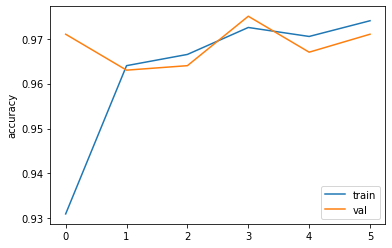

In [243]:
sns.lineplot(data=df_model_history, y="accuracy", x=amount_epochs, label="train")
sns.lineplot(data=df_model_history, y="val_accuracy", x=amount_epochs, label="val")

<AxesSubplot:ylabel='loss'>

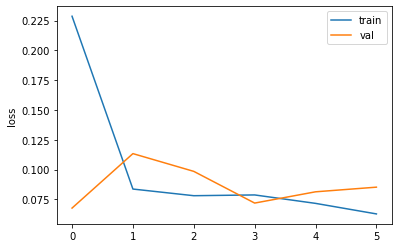

In [244]:
sns.lineplot(data=df_model_history, y="loss", x=amount_epochs, label="train")
sns.lineplot(data=df_model_history, y="val_loss", x=amount_epochs, label="val")

### Evaluate model

In [245]:

best_model = models.load_model('checkpoints/cnn_4_model_1_best_weights.hdf5')

In [246]:
test_loss, test_accuracy = evaluate_model(best_model, test_data)

2022-10-31 22:45:56.183851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 16s 436ms/step - loss: 0.0839 - accuracy: 0.9728


33/33 [==============================] - 19s 572ms/step


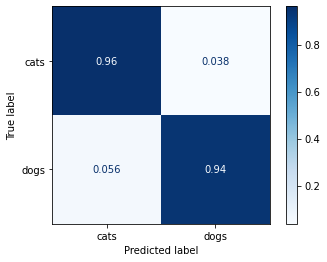

In [276]:
test_data.shuffle = False

y_pred = best_model.predict(test_data)

y_pred = np.argmax(y_pred, axis=1)
y_pred = y_pred.tolist()

confusion_matrix_model(test_data.classes, y_pred)

In [277]:
test_data.shuffle = True

## Create second model

In [249]:
second_model = create_model(input_shape, output_shape, "mobilenet")

In [250]:
second_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_6 (Flatten)         (None, 62720)             0         
                                                                 
 dense_40 (Dense)            (None, 256)               16056576  
                                                                 
 dense_41 (Dense)            (None, 256)               65792     
                                                                 
 dense_42 (Dense)            (None, 2)                 514       
                                                                 
Total params: 18,380,866
Trainable params: 16,122,882
Non-trainable params: 2,257,984
_________________________________

### Compile model

In [251]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                            filepath="checkpoints/cnn_4_model_2_best_weights.hdf5",
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [252]:
sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(learning_rate=1e-3, decay=1e-3 / 300)

compile_model(second_model, 'sparse_categorical_crossentropy', adam)

In [253]:
second_history = fit_model(second_model, train_data, validation_data=val_data, epochs=20, callbacks=[checkpoint_callback, es_callback])

Epoch 1/20


2022-10-31 22:46:32.528966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 1.5270 - accuracy: 0.8800

2022-10-31 22:46:57.903279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.35292, saving model to checkpoints/cnn_4_model_2_best_weights.hdf5
63/63 [==============================] - 42s 589ms/step - loss: 1.5270 - accuracy: 0.8800 - val_loss: 0.3529 - val_accuracy: 0.9520
Epoch 2/20
63/63 [==============================] - ETA: 0s - loss: 0.2877 - accuracy: 0.9385
Epoch 2: val_loss did not improve from 0.35292
63/63 [==============================] - 32s 504ms/step - loss: 0.2877 - accuracy: 0.9385 - val_loss: 0.7680 - val_accuracy: 0.9200
Epoch 3/20
63/63 [==============================] - ETA: 0s - loss: 0.3469 - accuracy: 0.9395
Epoch 3: val_loss improved from 0.35292 to 0.28275, saving model to checkpoints/cnn_4_model_2_best_weights.hdf5
63/63 [==============================] - 32s 504ms/step - loss: 0.3469 - accuracy: 0.9395 - val_loss: 0.2827 - val_accuracy: 0.9400
Epoch 4/20
63/63 [==============================] - ETA: 0s - loss: 0.2065 - accuracy: 0.9500
Epoch 4: val_loss improved from 0.28275 to 0.25088, sa

### Study model

In [254]:
df_model_history = pd.DataFrame(second_history.history)
df_model_history

,loss,accuracy,val_loss,val_accuracy
0,1.527036,0.8800,0.352919,0.952
1,0.287704,0.9385,0.767974,0.920
2,0.346921,0.9395,0.282747,0.940
3,0.206508,0.9500,0.250883,0.941
4,0.186109,0.9500,0.173124,0.952
5,0.198795,0.9450,0.168126,0.957
6,0.235543,0.9435,0.160510,0.954
7,0.135905,0.9605,0.143182,0.962
8,0.105826,0.9625,0.133296,0.963
9,0.106187,0.9605,0.128342,0.963


In [255]:
amount_epochs = np.arange(0, df_model_history.shape[0])

<AxesSubplot:ylabel='accuracy'>

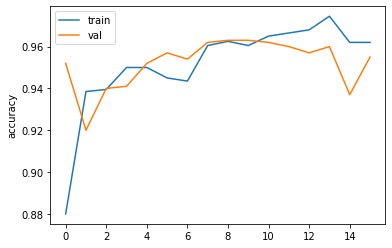

In [256]:
sns.lineplot(data=df_model_history, y="accuracy", x=amount_epochs, label="train")
sns.lineplot(data=df_model_history, y="val_accuracy", x=amount_epochs, label="val")

<AxesSubplot:ylabel='loss'>

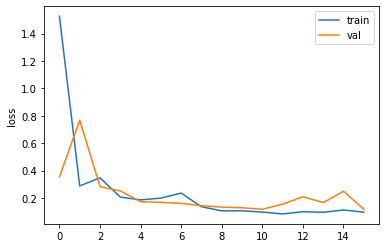

In [257]:
sns.lineplot(data=df_model_history, y="loss", x=amount_epochs, label="train")
sns.lineplot(data=df_model_history, y="val_loss", x=amount_epochs, label="val")

### Evaluate model

In [279]:
best_model = models.load_model('checkpoints/cnn_4_model_2_best_weights.hdf5')

In [280]:
test_loss, test_accuracy = evaluate_model(best_model, test_data)

2022-10-31 23:21:23.089706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 16s 405ms/step - loss: 0.1589 - accuracy: 0.9553


2022-10-31 23:21:39.158336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 14s 369ms/step


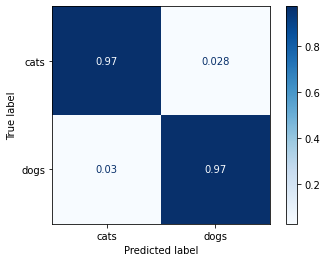

In [281]:
test_data.shuffle = False
y_pred = best_model.predict(test_data)

y_pred = np.argmax(y_pred, axis=1)
y_pred = y_pred.tolist()

confusion_matrix_model(test_data.classes, y_pred)

In [282]:
test_data.shuffle = True

## Create third model

In [262]:
third_model = create_model(input_shape, output_shape, model_type="densenet")

In [263]:
third_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 flatten_7 (Flatten)         (None, 94080)             0         
                                                                 
 dense_43 (Dense)            (None, 256)               24084736  
                                                                 
 dense_44 (Dense)            (None, 256)               65792     
                                                                 
 dense_45 (Dense)            (None, 2)                 514       
                                                                 
Total params: 42,473,026
Trainable params: 24,151,042
Non-trainable params: 18,321,984
_________________________________________________________________


### Compile model

In [264]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                            filepath="checkpoints/cnn_4_model_3_best_weights.hdf5",
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [265]:
sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(learning_rate=1e-3, decay=1e-3 / 300)

compile_model(third_model, 'sparse_categorical_crossentropy', adam)

In [266]:
third_history = fit_model(third_model, train_data, validation_data=val_data, epochs=35, callbacks=[checkpoint_callback, es_callback])

Epoch 1/35


2022-10-31 22:55:41.952686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 2.0424 - accuracy: 0.8750

2022-10-31 22:56:39.618145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.25334, saving model to checkpoints/cnn_4_model_3_best_weights.hdf5
63/63 [==============================] - 124s 2s/step - loss: 2.0424 - accuracy: 0.8750 - val_loss: 0.2533 - val_accuracy: 0.9570
Epoch 2/35
63/63 [==============================] - ETA: 0s - loss: 0.2178 - accuracy: 0.9395
Epoch 2: val_loss improved from 0.25334 to 0.18309, saving model to checkpoints/cnn_4_model_3_best_weights.hdf5
63/63 [==============================] - 169s 3s/step - loss: 0.2178 - accuracy: 0.9395 - val_loss: 0.1831 - val_accuracy: 0.9500
Epoch 3/35
63/63 [==============================] - ETA: 0s - loss: 0.2061 - accuracy: 0.9335 
Epoch 3: val_loss did not improve from 0.18309
63/63 [==============================] - 782s 13s/step - loss: 0.2061 - accuracy: 0.9335 - val_loss: 0.3809 - val_accuracy: 0.9190
Epoch 4/35
63/63 [==============================] - ETA: 0s - loss: 0.2046 - accuracy: 0.9380
Epoch 4: val_loss improved from 0.18309 to 0.10647, saving

### Study model

In [267]:
df_model_history = pd.DataFrame(third_history.history)
df_model_history

,loss,accuracy,val_loss,val_accuracy
0,2.042410,0.8750,0.253343,0.957
1,0.217843,0.9395,0.183087,0.950
2,0.206084,0.9335,0.380943,0.919
3,0.204599,0.9380,0.106467,0.953
4,0.192694,0.9370,0.184428,0.933
5,0.126489,0.9515,0.108377,0.963
6,0.123981,0.9580,0.114181,0.954
7,0.156720,0.9450,0.135445,0.956
8,0.133977,0.9500,0.133784,0.953


In [268]:
amount_epochs = np.arange(0, df_model_history.shape[0])

<AxesSubplot:ylabel='accuracy'>

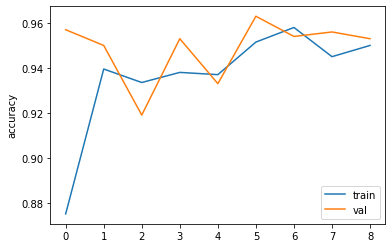

In [269]:
sns.lineplot(data=df_model_history, y="accuracy", x=amount_epochs, label="train")
sns.lineplot(data=df_model_history, y="val_accuracy", x=amount_epochs, label="val")

<AxesSubplot:ylabel='loss'>

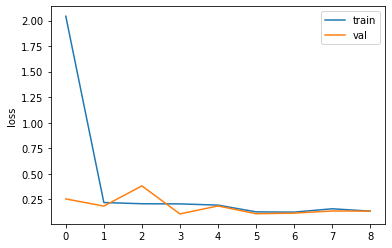

In [270]:
sns.lineplot(data=df_model_history, y="loss", x=amount_epochs, label="train")
sns.lineplot(data=df_model_history, y="val_loss", x=amount_epochs, label="val")

### Evaluate model

In [271]:
best_model = models.load_model('checkpoints/cnn_4_model_3_best_weights.hdf5')

In [272]:
test_loss, test_accuracy = evaluate_model(best_model, test_data)

2022-10-31 23:18:49.165787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 40s 935ms/step - loss: 0.1610 - accuracy: 0.9427


33/33 [==============================] - 11s 318ms/step


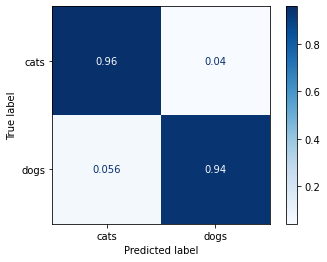

In [283]:
test_data.shuffle = False

y_pred = best_model.predict(test_data)

y_pred = np.argmax(y_pred, axis=1)
y_pred = y_pred.tolist()

confusion_matrix_model(test_data.labels, y_pred)

In [284]:
test_data.shuffle = True

## Visualize layers

In [275]:
layer_outputs = [layer.output for layer in best_model.layers[:12]] 
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=best_model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_15'), name='input_15', description="created by layer 'input_15'") at layer "zero_padding2d_2". The following previous layers were accessed without issue: []

In [ ]:
#activations = activation_model.predict(test_data) 
# Returns a list of five Numpy arrays: one array per layer activation

In [ ]:
layer_names = []
for layer in best_model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    print(layer_name)
    if ("flatten" in layer_name): break

    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

NameError: name 'activations' is not defined

## Conclusion

- Report the accuracy for each model.  Which was the highest? Why?
  - First model: 0.9728
  - Second model: 0.9553
  - Third model: 0.9427

The first model was the best, but why i couldn't say, the reason i think is because first the second model was designed to be more efficient, so it has less complexity, so probably thats the reason why the second model was worse than the first. And for why the third model was worst than the first, well maybe it was because the model didn't have a lot of neurons in the hidden dense layers (i use the same layers for all the models), because at least in the keras page it says that densenet is better than resnet for the benchmarks they have, so i dont have a concrete explanation as to why the first model was better than the first one.

- Report the training and validation loss. Which was the lowest? Why?
  - First model: 0.0839
  - Second model: 0.1589
  - Third model: 0.1610

Again the first model was the best one, and the reasons why i would say the same i said in the first question, but i'm not 100% sure why.
  
- Make a conclusion about the task you have done.
  - Well for this activity i could see how models already trained can be reused to extract features for a new problem and create a model around this one or just use that model for your problem and you don't need to train it, because lets say that the image you want to predict is one which the resnet model was already trained, in this case we can just use the model as it is and thats it.